# Financial News Sentiment Analysis
In this notebook, we will perform sentiment analysis on financial news. The outputs will be classified as positive, negative, or neutral.

In [4]:
# Import all required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import lightgbm as lgb
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import os
import joblib
import pickle
import re
from string import punctuation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# NOTE: Run this section only once to download NLTK datasets
# After running once successfully, you can comment out the section below
"""
# Set the directory for NLTK data
nltk_data_dir = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'nltk_data')
if not os.path.exists(nltk_data_dir):
    os.makedirs(nltk_data_dir)

# Configure NLTK data directory
nltk.data.path.insert(0, nltk_data_dir)

# Download required NLTK datasets
print("Downloading NLTK datasets...")
for dataset in ['punkt', 'stopwords', 'wordnet', 'omw-1.4']:
    print(f"Downloading {dataset}...")
    nltk.download(dataset, download_dir=nltk_data_dir, quiet=True)
    print(f"{dataset} downloaded.")

# Verify downloaded datasets
print("\nVerifying NLTK datasets...")
try:
    # Test dataset usage
    word_tokenize("Test sentence")
    stopwords.words('english')
    lemmatizer = WordNetLemmatizer()
    lemmatizer.lemmatize("testing")
    print("All NLTK datasets successfully loaded and tested.")
except LookupError as e:
    print(f"Error: {str(e)}")
    print("An error occurred while loading NLTK datasets.")
"""

'\n# Set the directory for NLTK data\nnltk_data_dir = os.path.join(os.path.dirname(os.path.abspath(\'__file__\')), \'nltk_data\')\nif not os.path.exists(nltk_data_dir):\n    os.makedirs(nltk_data_dir)\n\n# Configure NLTK data directory\nnltk.data.path.insert(0, nltk_data_dir)\n\n# Download required NLTK datasets\nprint("Downloading NLTK datasets...")\nfor dataset in [\'punkt\', \'stopwords\', \'wordnet\', \'omw-1.4\']:\n    print(f"Downloading {dataset}...")\n    nltk.download(dataset, download_dir=nltk_data_dir, quiet=True)\n    print(f"{dataset} downloaded.")\n\n# Verify downloaded datasets\nprint("\nVerifying NLTK datasets...")\ntry:\n    # Test dataset usage\n    word_tokenize("Test sentence")\n    stopwords.words(\'english\')\n    lemmatizer = WordNetLemmatizer()\n    lemmatizer.lemmatize("testing")\n    print("All NLTK datasets successfully loaded and tested.")\nexcept LookupError as e:\n    print(f"Error: {str(e)}")\n    print("An error occurred while loading NLTK datasets.")\n'

## Loading and Exploring the Dataset

In [5]:
# Load the dataset
df = pd.read_csv('../data/sentiment_data.csv', header=None, names=['text', 'sentiment'])

print("Initial dataset size:", len(df))
df.head()

Initial dataset size: 5843


,text,sentiment
0,Sentence,Sentiment
1,The GeoSolutions technology will leverage Bene...,positive
2,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
3,"For the last quarter of 2010 , Componenta 's n...",positive
4,According to the Finnish-Russian Chamber of Co...,neutral


In [6]:
# Data cleaning and encoding: map sentiment labels directly to numeric values
def encode_sentiment(s):
    """
    Encode sentiment labels to numeric values for model training.
    
    Args:
        s (str): Input sentiment label
        
    Returns:
        int: Encoded sentiment value
            - 2: negative
            - 1: positive
            - 0: neutral
            - None: unknown values
    """
    s = str(s).lower().strip()
    if s in ['negative', 'neg', '-1']:
        return 2  # negative -> 2
    elif s in ['neutral', 'neu', '0']:
        return 0  # neutral -> 0
    elif s in ['positive', 'pos', '1']:
        return 1  # positive -> 1
    else:
        return None  # for unknown values

# Apply encoding
df['sentiment_encoded'] = df['sentiment'].apply(encode_sentiment)

In [7]:
# Remove rows with unknown sentiment (None values)
unknown_count = df['sentiment_encoded'].isna().sum()
if unknown_count > 0:
    print(f"Removing {unknown_count} records with unknown sentiment values")
    df = df.dropna(subset=['sentiment_encoded'])

print("Dataset size after removing unknown labels:", len(df))

# Convert encoded values to int type
df['sentiment_encoded'] = df['sentiment_encoded'].astype(int)

Removing 1 records with unknown sentiment values
Dataset size after removing unknown labels: 5842


In [8]:
# Display sentiment distribution with Plotly
sentiment_counts = df['sentiment'].value_counts().reset_index()
sentiment_counts.columns = ['sentiment', 'count']

# Create interactive bar chart
fig = px.bar(sentiment_counts, 
             x='sentiment', 
             y='count',
             title='Sentiment Distribution in Dataset',
             labels={'sentiment': 'Sentiment Category', 'count': 'Number of Examples'},
             color='sentiment',
             color_discrete_map={'positive': '#2ecc71', 'negative': '#e74c3c', 'neutral': '#3498db'},
             text='count')

fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.update_layout(showlegend=False, 
                  xaxis_title='Sentiment Category',
                  yaxis_title='Count',
                  title_x=0.5)
fig.show()

# Print distribution statistics
print("\nSentiment Distribution:")
for idx, row in sentiment_counts.iterrows():
    percentage = (row['count'] / len(df)) * 100
    print(f"{row['sentiment']}: {row['count']} ({percentage:.2f}%)")


Sentiment Distribution:
neutral: 3130 (53.58%)
positive: 1852 (31.70%)
negative: 860 (14.72%)


In [9]:
# Remove duplicate entries based on text
duplicate_count = df.duplicated(subset=['text']).sum()
if duplicate_count > 0:
    print(f"Removing {duplicate_count} duplicate records")
    df = df.drop_duplicates(subset=['text'], keep='first')
    print("Dataset size after removing duplicates:", len(df))

Removing 520 duplicate records
Dataset size after removing duplicates: 5322


In [49]:
# Store the mapping for reference
sentiment_mapping = {
    'negative': 2,
    'neutral': 0,
    'positive': 1
}
print("\nSentiment Label Mapping:")
for sentiment, code in sentiment_mapping.items():
    print(f"{sentiment} -> {code}")


Sentiment Label Mapping:
negative -> 2
neutral -> 0
positive -> 1


In [50]:
# Display the distribution of sentiment classes
print("Distribution of sentiment classes:")
sentiment_counts = df['sentiment_encoded'].map({2: 'negative', 0: 'neutral', 1: 'positive'}).value_counts()
print(sentiment_counts)

Distribution of sentiment classes:
sentiment_encoded
neutral     2878
positive    1852
negative     592
Name: count, dtype: int64


In [51]:
# Display first few rows of the cleaned dataset
print(df[['text', 'sentiment', 'sentiment_encoded']].head())

                                                text sentiment  \
1  The GeoSolutions technology will leverage Bene...  positive   
2  $ESI on lows, down $1.50 to $2.50 BK a real po...  negative   
3  For the last quarter of 2010 , Componenta 's n...  positive   
4  According to the Finnish-Russian Chamber of Co...   neutral   
5  The Swedish buyout firm has sold its remaining...   neutral   

   sentiment_encoded  
1                  1  
2                  2  
3                  1  
4                  0  
5                  0  


## Text Preprocessing
1. Convert to lowercase
2. Remove punctuation
3. Remove stop words
4. Apply lemmatization

In [52]:
def preprocess_text(text):
    """
    Preprocess text data by applying various cleaning and normalization steps.
    
    Args:
        text (str): Raw input text to be preprocessed
        
    Returns:
        str: Cleaned and normalized text with the following transformations:
            - Converted to lowercase
            - Removed URLs, email addresses, stock symbols
            - Removed percentages and currency amounts
            - Removed special characters and numbers
            - Tokenized and removed stop words
            - Applied lemmatization
            - Removed short words (length < 3)
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove stock symbols (e.g., $AAPL, $GOOG)
    text = re.sub(r'\$\w+', '', text)
    
    # Remove numbers with % (percentage)
    text = re.sub(r'\d+%', '', text)
    
    # Remove currency symbols and amounts (e.g., $123.45, €100, £50)
    text = re.sub(r'[$€£¥]\d+(?:\.\d{2})?|\d+(?:\.\d{2})?[$€£¥]', '', text)
    
    # Remove special characters and numbers
    # Keep alphabets and spaces
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatization with pos tagging for better accuracy
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token, pos='v') for token in tokens]  # First try as verb
    tokens = [lemmatizer.lemmatize(token, pos='n') for token in tokens]  # Then as noun
    
    # Remove short words (length < 3)
    tokens = [token for token in tokens if len(token) > 2]
    
    return ' '.join(tokens)

# Preprocess texts in the dataset
df['processed_text'] = df['text'].apply(preprocess_text)

print(df[['processed_text']].head())

                                      processed_text
1  geosolutions technology leverage benefon gps s...
2                               low real possibility
3  last quarter componenta net sale double eur eu...
4  accord finnish russian chamber commerce major ...
5  swedish buyout firm sell remain percent stake ...


In [53]:
# Check word count and filter
df['word_count'] = df['processed_text'].apply(lambda x: len(str(x).split()))
original_size = len(df)

# Remove examples with less than 4 words
df = df[df['word_count'] >= 4]

print(f"Original dataset size: {original_size}")
print(f"Filtered dataset size: {len(df)}")
print(f"Number of removed examples: {original_size - len(df)}")

# Display examples of processed texts with original for comparison
df_comparison = pd.DataFrame({
    'Original Text': df['text'],
    'Processed Text': df['processed_text'],
    'Word Count': df['word_count']
})
print(df_comparison.head())

Original dataset size: 5322
Filtered dataset size: 5080
Number of removed examples: 242
                                       Original Text  \
1  The GeoSolutions technology will leverage Bene...   
3  For the last quarter of 2010 , Componenta 's n...   
4  According to the Finnish-Russian Chamber of Co...   
5  The Swedish buyout firm has sold its remaining...   
6    $SPY wouldn't be surprised to see a green close   

                                      Processed Text  Word Count  
1  geosolutions technology leverage benefon gps s...          21  
3  last quarter componenta net sale double eur eu...          20  
4  accord finnish russian chamber commerce major ...          11  
5  swedish buyout firm sell remain percent stake ...          14  
6                           surprise see green close           4  


## Model Comparison
1. Logistic Regression
2. Random Forest Classifier
3. Support Vector Machine (SVM)
4. Naive Bayes
5. XGBoost

Each model will be evaluated using:
- Accuracy
- Precision, Recall, F1-Score
- Confusion Matrix

## Data Split and Feature Engineering

In [54]:
print("Class distribution before sampling:")
print(df['sentiment'].value_counts())

Class distribution before sampling:
sentiment
neutral     2770
positive    1754
negative     556
Name: count, dtype: int64


In [55]:
# Perform train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    df['processed_text'], 
    df['sentiment_encoded'],
    test_size=0.2, 
    random_state=9,
    stratify=df['sentiment_encoded']
)

print("Training set size:", len(X_train))
print("Test set size:", len(X_test))

Training set size: 4064
Test set size: 1016


In [ ]:
# TF-IDF Vectorization with enhanced parameters
tfidf = TfidfVectorizer(
    max_features=5000,
    min_df=2,  # Ignore terms that appear in less than 2 documents
    max_df=0.90,  # Ignore terms that appear in more than 90% of documents
    ngram_range=(1, 2),  # Include both unigrams and bigrams
)

# Transform the text data and convert to dense arrays
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()

print("Feature matrix shape:")
print("Training set:", X_train_tfidf.shape)
print("Test set:", X_test_tfidf.shape)

Feature matrix shape:
Training set: (4064, 5000)
Test set: (1016, 5000)


### Save TF-IDF Vector

In [57]:
with open("../models/tfidf_vector.pkl", "wb") as file:
    pickle.dump(tfidf, file)

## Default Model

In [58]:
models = {
    'Logistic Regression': LogisticRegression(
        multi_class='multinomial',  # Specific for multiclass
        solver='lbfgs',            # Best solver for multinomial
        max_iter=1000,             # Increased for convergence
        random_state=9
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,          # Default value
        criterion='gini',          # Default, good for multiclass
        random_state=9
    ),
    'SVM': SVC(
        kernel='rbf',              # Default value
        decision_function_shape='ovo',  # One-vs-one for multiclass
        probability=True,
        random_state=9
    ),
    'Naive Bayes': MultinomialNB(),
    'XGBoost': xgb.XGBClassifier(
        objective='multi:softmax',  # Specific for multiclass
        num_class=3,
        random_state=9
    ),
    'LightGBM': lgb.LGBMClassifier(
        objective='multiclass',     # Specific for multiclass
        num_class=3,
        random_state=9
    )
}

In [62]:
results = {}

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=9)

for name, model in models.items():
    try:
        print(f"\nTraining {name}...")
        
        cv_scores = cross_val_score(
            model, 
            X_train_tfidf,
            y_train, 
            cv=skf, 
            scoring='f1_weighted',
            n_jobs=-1
        )
        
        print(f"Cross-validation f1-scores: {cv_scores}")
        print(f"Mean CV f1-score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        
        model.fit(X_train_tfidf, y_train)
        y_pred = model.predict(X_test_tfidf)
        
        # Store results
        results[name] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'f1_score': f1_score(y_test, y_pred, average='weighted'),
            'classification_report': classification_report(y_test, y_pred),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'cv_scores': cv_scores
        }
        
        # Print results
        print(f"\n{name} Results:")
        print(f"Test Accuracy: {results[name]['accuracy']:.4f}")
        print(f"Test F1-Score: {results[name]['f1_score']:.4f}")
        # print("\nClassification Report:")
        # print(results[name]['classification_report'])
        print("-"*50)
    
    except Exception as e:
        print(f"\nError training {name}:")
        print(str(e))
        continue


Training Logistic Regression...
Cross-validation f1-scores: [0.68432605 0.69247653 0.69608195]
Mean CV f1-score: 0.6910 (+/- 0.0098)

Logistic Regression Results:
Test Accuracy: 0.7451
Test F1-Score: 0.7170
--------------------------------------------------

Training Random Forest...
Cross-validation f1-scores: [0.66232673 0.68608937 0.70075198]
Mean CV f1-score: 0.6831 (+/- 0.0317)

Random Forest Results:
Test Accuracy: 0.7402
Test F1-Score: 0.7208
--------------------------------------------------

Training SVM...
Cross-validation f1-scores: [0.67362936 0.66313529 0.6776953 ]
Mean CV f1-score: 0.6715 (+/- 0.0123)

SVM Results:
Test Accuracy: 0.7333
Test F1-Score: 0.7008
--------------------------------------------------

Training Naive Bayes...
Cross-validation f1-scores: [0.65184012 0.64716717 0.6564994 ]
Mean CV f1-score: 0.6518 (+/- 0.0076)

Naive Bayes Results:
Test Accuracy: 0.7077
Test F1-Score: 0.6647
--------------------------------------------------

Training XGBoost...
Cro

In [66]:
# Find the top 3 performing models based on Cross-Validation F1-scores

# Sort models by mean CV F1-score instead of test F1-score
sorted_models = sorted(results.items(), key=lambda x: x[1]['cv_scores'].mean(), reverse=True)[:3]
print("\nTop 3 performing models (ranked by CV F1-scores):")
for name, result in sorted_models:
    print(f"\n{name}:")
    print(f"Mean CV F1-Score: {result['cv_scores'].mean():.4f} (+/- {result['cv_scores'].std() * 2:.4f})")
    print(f"Test Set F1-Score: {result['f1_score']:.4f}")

# Store top 3 model names for later use
top_3_models = [name for name, _ in sorted_models]


Top 3 performing models (ranked by CV F1-scores):

Logistic Regression:
Mean CV F1-Score: 0.6910 (+/- 0.0098)
Test Set F1-Score: 0.7170

Random Forest:
Mean CV F1-Score: 0.6831 (+/- 0.0317)
Test Set F1-Score: 0.7208

XGBoost:
Mean CV F1-Score: 0.6761 (+/- 0.0162)
Test Set F1-Score: 0.7127


## Hyperparameter Optimization for Top 3 Models

In [67]:
# Define parameter grids for top 3 models
param_grids = {
    'Logistic Regression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
        'multi_class': ['multinomial'],
        'max_iter': [1000, 2000]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 'auto'],
        'class_weight': ['balanced', None]
    },
    'Naive Bayes': {
        'alpha': [0.1, 0.5, 1.0, 2.0],
        'fit_prior': [True, False]
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'criterion': ['gini', 'entropy']
    },
    'LightGBM': {
        'num_leaves': [31, 63, 127],
        'max_depth': [5, 7, 9],
        'learning_rate': [0.01, 0.1, 0.3],
        'n_estimators': [200, 300, 400],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'min_child_samples': [20, 40, 60]
    },
    'XGBoost': {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [100, 200, 300],
        'min_child_weight': [1, 3, 5],
        'gamma': [0, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0]
    }
}

Optimizing first model: Logistic Regression
Fitting 3 folds for each of 48 candidates, totalling 144 fits

Best parameters for Logistic Regression:
{'C': 10, 'max_iter': 1000, 'multi_class': 'multinomial', 'solver': 'newton-cg'}
Best cross-validation f1-score: 0.7063
Test F1-score: 0.7230
Test accuracy: 0.7333

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.85      0.80       554
           1       0.73      0.69      0.71       351
           2       0.49      0.30      0.37       111

    accuracy                           0.73      1016
   macro avg       0.66      0.61      0.63      1016
weighted avg       0.72      0.73      0.72      1016


Best parameters for Logistic Regression:
{'C': 10, 'max_iter': 1000, 'multi_class': 'multinomial', 'solver': 'newton-cg'}
Best cross-validation f1-score: 0.7063
Test F1-score: 0.7230
Test accuracy: 0.7333

Classification Report:
              precision    recall  f1-score   support

Optimizing first model: Logistic Regression
Fitting 3 folds for each of 48 candidates, totalling 144 fits

Best parameters for Logistic Regression:
{'C': 10, 'max_iter': 1000, 'multi_class': 'multinomial', 'solver': 'newton-cg'}
Best cross-validation f1-score: 0.7063
Test F1-score: 0.7230
Test accuracy: 0.7333

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.85      0.80       554
           1       0.73      0.69      0.71       351
           2       0.49      0.30      0.37       111

    accuracy                           0.73      1016
   macro avg       0.66      0.61      0.63      1016
weighted avg       0.72      0.73      0.72      1016


Best parameters for Logistic Regression:
{'C': 10, 'max_iter': 1000, 'multi_class': 'multinomial', 'solver': 'newton-cg'}
Best cross-validation f1-score: 0.7063
Test F1-score: 0.7230
Test accuracy: 0.7333

Classification Report:
              precision    recall  f1-score   support

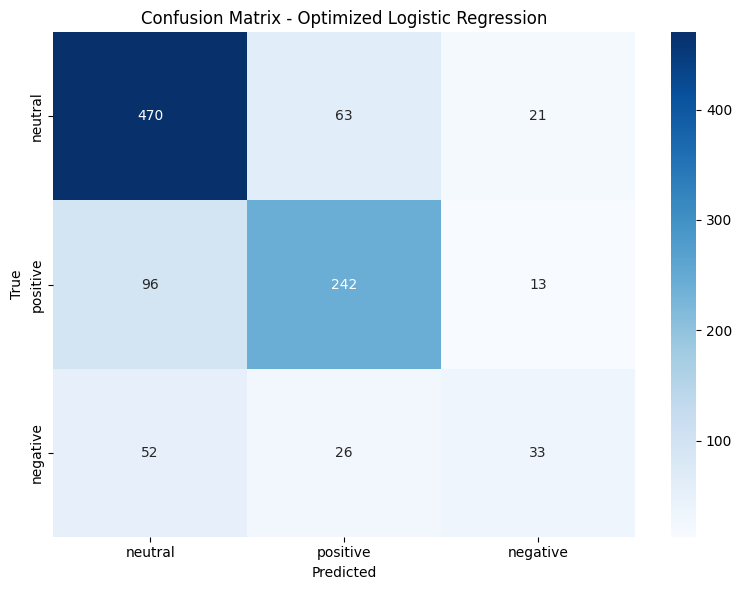

In [68]:
# Hyperparameter optimization for the best performing model (1st)
print("Optimizing first model:", top_3_models[0])
first_model = models[top_3_models[0]]
first_grid = GridSearchCV(
    estimator=first_model,
    param_grid=param_grids[top_3_models[0]],
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=9),
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

first_grid.fit(X_train_tfidf, y_train)

print(f"\nBest parameters for {top_3_models[0]}:")
print(first_grid.best_params_)
print(f"Best cross-validation f1-score: {first_grid.best_score_:.4f}")

# Evaluate on test set
y_pred = first_grid.predict(X_test_tfidf)
test_f1 = f1_score(y_test, y_pred, average='weighted')
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test F1-score: {test_f1:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=['neutral', 'positive', 'negative'],
            yticklabels=['neutral', 'positive', 'negative'])
plt.title(f'Confusion Matrix - Optimized {top_3_models[0]}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [ ]:
# Hyperparameter optimization for the second best model
print("\nOptimizing second model:", top_3_models[1])
second_model = models[top_3_models[1]]
second_grid = GridSearchCV(
    estimator=second_model,
    param_grid=param_grids[top_3_models[1]],
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

second_grid.fit(X_train_tfidf, y_train)

# Print results
print(f"\nBest parameters for {top_3_models[1]}:")
print(second_grid.best_params_)
print(f"Best cross-validation accuracy: {second_grid.best_score_:.4f}")

# Evaluate on test set
y_pred = second_grid.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {test_accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=['neutral', 'positive', 'negative'],
            yticklabels=['neutral', 'positive', 'negative'])
plt.title(f'Confusion Matrix - Optimized {top_3_models[1]}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


Optimizing second model: Random Forest
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Best parameters for Random Forest:
{'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.7219
Test accuracy: 0.7441

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.90      0.81       554
           1       0.78      0.66      0.71       351
           2       0.58      0.23      0.32       111

    accuracy                           0.74      1016
   macro avg       0.70      0.60      0.62      1016
weighted avg       0.74      0.74      0.73      1016



In [ ]:
# Hyperparameter optimization for the third best model
print("\nOptimizing third model:", top_3_models[2])
third_model = models[top_3_models[2]]
third_grid = GridSearchCV(
    estimator=third_model,
    param_grid=param_grids[top_3_models[2]],
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

third_grid.fit(X_train_tfidf, y_train)

# Print results
print(f"\nBest parameters for {top_3_models[2]}:")
print(third_grid.best_params_)
print(f"Best cross-validation accuracy: {third_grid.best_score_:.4f}")

# Evaluate on test set
y_pred = third_grid.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {test_accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=['neutral', 'positive', 'negative'],
            yticklabels=['neutral', 'positive', 'negative'])
plt.title(f'Confusion Matrix - Optimized {top_3_models[2]}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

## Model Testing

In [ ]:
# Compare cross-validation scores from hyperparameter tuning
cv_scores = {
    top_3_models[0]: first_grid.best_score_,
    top_3_models[1]: second_grid.best_score_,
    top_3_models[2]: third_grid.best_score_
}

# Get the name of the best performing model
best_model_name = max(cv_scores.items(), key=lambda x: x[1])[0]
print(f"\nBest performing model after hyperparameter tuning: {best_model_name}")
print(f"Best cross-validation score: {cv_scores[best_model_name]:.4f}")

# Create a dictionary of optimized models
optimized_models = {
    top_3_models[0]: first_grid.best_estimator_,
    top_3_models[1]: second_grid.best_estimator_,
    top_3_models[2]: third_grid.best_estimator_
}

# Assign the best model to best_model variable
best_model = optimized_models[best_model_name]
print("\nBest model parameters:")
print(best_model.get_params())

In [ ]:
# Function for predicting sentiment of new texts
def predict_sentiment(text):
    """
    Predict sentiment of input text using the trained model.
    
    Args:
        text (str): Input text for sentiment analysis
        
    Returns:
        str: Predicted sentiment label ('neutral', 'positive', or 'negative')
            - 'neutral': Text shows no clear positive or negative sentiment
            - 'positive': Text shows positive sentiment
            - 'negative': Text shows negative sentiment
    """
    # Preprocess text
    processed = preprocess_text(text)
    # TF-IDF transformation and convert to dense array
    text_tfidf = tfidf.transform([processed]).toarray()
    
    # Get numeric prediction
    prediction_encoded = best_model.predict(text_tfidf)[0]
    
    # Convert numeric prediction to sentiment label
    sentiment_labels = {0: 'neutral', 1: 'positive', 2: 'negative'}
    prediction = sentiment_labels[prediction_encoded]
    
    return prediction

In [ ]:
# Test examples
test_texts = [
    "Stock market reaches all-time high as tech sector booms",
    "Company announces massive layoffs amid financial troubles",
    "Market remains stable as Fed maintains current interest rates"
]

# Make predictions on test examples
print("Test Results:")
for text in test_texts:
    sentiment = predict_sentiment(text)
    print(f"\nText: {text}")
    print(f"Predicted sentiment: {sentiment}")

## Model Save

In [ ]:
# Define the directory to save the model
model_dir = '../models/'
os.makedirs(model_dir, exist_ok=True)

# Define the path for the saved model file
model_path = os.path.join(model_dir, 'sentiment_model.pkl')

# Save the best performing model
joblib.dump(best_model, model_path)

print(f"Best performing model saved to: {model_path}")

In [ ]:
# Load the saved model
loaded_model_path = '../models/sentiment_model.pkl'
loaded_model = joblib.load(loaded_model_path)

# Test with a new text
new_text = "The company's earnings report exceeded expectations."
predicted_sentiment = predict_sentiment(new_text)

print(f"\nNew text: {new_text}")
print(f"Predicted sentiment: {predicted_sentiment}")